In [339]:
import warnings                                                 # библиотека ддя отключения предупреждений
import nltk                                                     # библиотека для обработки текста
import string                                                   # библиотека, содержащая почти всю пунктуацию
import pickle                                                   # библиотека для сохранения модели
import pandas as pd                                             # библиотека для чтения и записи данных

from xgboost import XGBClassifier                               # модель xgboost для обучения
import matplotlib.pyplot as plt                                 # библиотека для визуализации данных
from tqdm import tqdm                                           # библиотека для визуализации процессов
from collections import Counter                                 # функция для подсчёта повторов слов в данных
from nltk.corpus import stopwords                               # список стоп-слов
from nltk.stem import SnowballStemmer                           # функция для обработки слов
from nltk.tokenize import word_tokenize                         # функция для токинизирования слов
from sklearn.model_selection import train_test_split            # библиотека для разделения на тренировочную и тестовую выборки
from sklearn.feature_extraction.text import TfidfVectorizer     # функция для векторизации предложения
from sklearn.linear_model import LogisticRegression             # линейная модуль для обучения
from sklearn.metrics import classification_report               # метрика
from sklearn.ensemble import GradientBoostingClassifier         # ещё модель

In [236]:
warnings.filterwarnings("ignore")

In [237]:
data_train = pd.read_csv("train.csv", sep="\t")

In [238]:
data_train.head()

,idx,Score,Text
0,0,Positive,В Альфа-Банке работает замечательная девушка -...
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,2,Positive,Очень порадовала оперативность работы в банке....
3,3,Negative,Имела неосторожность оформить потреб. кредит в...
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...


In [239]:
data_train = data_train.drop("idx", axis=1)

In [240]:
data_train.Score = data_train.Score.apply(lambda x: 1 if x == "Positive" else 0)

In [241]:
data_train.head()

,Score,Text
0,1,В Альфа-Банке работает замечательная девушка -...
1,0,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,1,Очень порадовала оперативность работы в банке....
3,0,Имела неосторожность оформить потреб. кредит в...
4,0,Небольшая предыстория: Нашел на сайте MDM банк...


In [242]:
data_train.size

27998

In [243]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13999 entries, 0 to 13998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Score   13999 non-null  int64 
 1   Text    13999 non-null  object
dtypes: int64(1), object(1)
memory usage: 218.9+ KB


In [244]:
data_train.isna().sum()

Score    0
Text     0
dtype: int64

In [245]:
data_train = data_train.drop_duplicates()

Text(0.5, 1.0, 'Отношение сообщений')

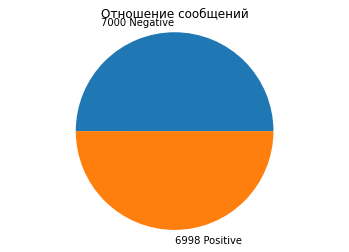

In [246]:
labels = [f"{len(data_train.loc[data_train.Score == 1])}" +
          " Negative", f"{len(data_train.loc[data_train.Score == 0])}" + " Positive"]
fig, ax = plt.subplots()
ax.pie([len(data_train.loc[data_train.Score == 1]), len(data_train.loc[data_train.Score == 0])], labels=labels)
ax.axis("equal")
plt.title("Отношение сообщений")

In [247]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


False

In [308]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")
punct = string.punctuation + "«–»“”"

In [309]:
def tokinize_sentence(sentence: str):
    sentence = sentence.strip().lower()
    sentence.replace("\t", " ")
    for i in punct:
        if i in sentence and i != " ":
            sentence = sentence.replace(i, ' ')
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    tokens = [i for i in tokens if i not in ["банк", "карт", "эт", "мо", "котор", "г", "т"]]
    return " ".join(tokens)

In [310]:
print(tokinize_sentence("123 abc Abc ACb., & банка "))

123 abc abc acb


In [311]:
tqdm.pandas()

data_token = data_train.copy()
data_token.Text = data_token.Text.progress_apply(lambda x: tokinize_sentence(x))
data_token.head()

100%|██████████| 13998/13998 [01:06<00:00, 209.66it/s]


,Score,Text
0,1,альф работа замечательн девушк ильясов орн веж...
1,0,оформл рассрочк м виде мег тепл стан попрос ме...
2,1,очен порадова оперативн работ заказа интернет ...
3,0,имел неосторожн оформ потреб кред альф очен жа...
4,0,небольш предыстор нашел сайт mdm интересн ко б...


In [312]:
data = data_token.copy()
empty = data[data.Text == '']
print('Количество пустых значений: ', len(empty))
data = data.drop(empty.index)

Количество пустых значений:  0


In [313]:
print('Дубликаты: ', data.duplicated().sum())

Дубликаты:  0


In [391]:
sorted_counter = Counter(' '.join(data_token.Text.values).split()).most_common()
sorted_counter[:5]

[('сотрудник', 6365),
 ('счет', 6035),
 ('клиент', 5998),
 ('отделен', 5814),
 ('деньг', 4540)]

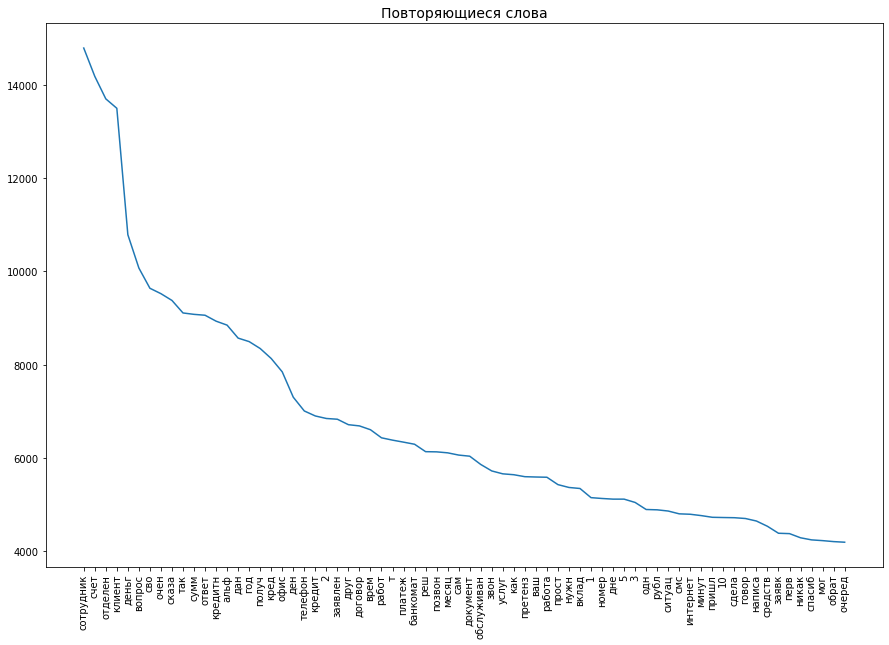

In [315]:
plt.figure(figsize=(15, 10))
plt.plot([i[0] for i in sorted_counter][:70], [i[1] for i in sorted_counter][:70])
plt.xticks(rotation=90)
plt.title('Повторяющиеся слова', fontsize=14)
plt.show()

In [316]:
data_test = pd.read_csv("test.csv", sep="\t")

In [392]:
data.head()

,Score,Text
0,1,альф работа замечательн девушк ильясов орн веж...
1,0,оформл рассрочк м виде мег тепл стан попрос ме...
2,1,очен порадова оперативн работ заказа интернет ...
3,0,имел неосторожн оформ потреб кред альф очен жа...
4,0,небольш предыстор нашел сайт mdm интересн ко б...


In [362]:
X_train, X_test, y_train, y_test = train_test_split(data["Text"], data["Score"], test_size=0.20, random_state=311)

In [363]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print('Фичи: ', len(vectorizer.get_feature_names()))

Фичи:  24207


In [364]:
with open("vectorizer.bf", "+wb") as file:
    pickle.dump(vectorizer, file)

In [365]:
model = LogisticRegression(max_iter=10000, C=3, solver='liblinear')

In [366]:
model.fit(X_train, y_train)

LogisticRegression(C=3, max_iter=10000, solver='liblinear')

In [367]:
y_pred = model.predict(X_test)

In [368]:
list(y_pred).count(0), list(y_pred).count(1), len(y_pred)

(1456, 1344, 2800)

In [369]:
list(y_test).count(0), list(y_test).count(1), len(y_test)

(1400, 1400, 2800)

In [370]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1400
           1       0.97      0.93      0.95      1400

    accuracy                           0.95      2800
   macro avg       0.95      0.95      0.95      2800
weighted avg       0.95      0.95      0.95      2800



In [371]:
toxic_propabality = model.predict_proba(vectorizer.transform([tokinize_sentence("БАНК фигня")]))[0, 1]
print(f'Probability of toxicity: {toxic_propabality:.3f}')

Probability of toxicity: 0.418


In [372]:
model2 = XGBClassifier()
model2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [373]:
y_pred = model2.predict(X_test)

In [374]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1400
           1       0.95      0.91      0.93      1400

    accuracy                           0.93      2800
   macro avg       0.93      0.93      0.93      2800
weighted avg       0.93      0.93      0.93      2800



In [375]:
model3 = GradientBoostingClassifier()

In [376]:
model3.fit(X_train, y_train)

GradientBoostingClassifier()

In [377]:
y_pred = model3.predict(X_test)

In [378]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1400
           1       0.94      0.89      0.91      1400

    accuracy                           0.92      2800
   macro avg       0.92      0.92      0.91      2800
weighted avg       0.92      0.92      0.91      2800



In [379]:
tqdm.pandas()

data_token = data_test.copy()
data_token.Text = data_token.Text.progress_apply(lambda x: tokinize_sentence(x))
data_token.head()

100%|██████████| 6000/6000 [00:29<00:00, 205.58it/s]


,idx,Text
0,13999,замечательн истор открыт счет авангард рост до...
1,14000,23 07 14г досрочн внес сумм указа оператор зак...
2,14001,задолжен кредитн пода суд приказн судопроизвод...
3,14002,срочн понадоб определен денежн сумм подума поч...
4,14003,здравств местн отделен бинбанк курчатов курск ...


In [380]:
# data_token.to_csv("adfasd.csv")

In [381]:
X_test = vectorizer.transform(data_token.Text)

In [382]:
y_pred = model.predict(X_test)

In [383]:
data_result = pd.DataFrame()
data_result["idx"] = data_token.idx
data_result = data_result.set_index("idx")
data_result["Score"] = y_pred.copy()
data_result.Score = data_result.Score.apply(lambda x: "Positive" if x == 1 else "Negative")

In [384]:
data_result.head()

,Score
idx,
13999,Negative
14000,Negative
14001,Negative
14002,Negative
14003,Negative


In [385]:
data_result.to_csv("answer.csv", sep="\t")